In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import mstats
import warnings
import pickle

warnings.filterwarnings("ignore")

## Load the Dataset

In [2]:
file_path = 'Multiple Classification - EV Battery Faults Dataset.xlsx'
df = pd.read_excel(file_path)

## Step 1: Exploratory Data Analysis (EDA)

In [3]:
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SoC          1152 non-null   float64
 1   Temperature  1152 non-null   float64
 2   Voltage      1152 non-null   float64
 3   Label        1152 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 36.1 KB
None

First 5 Rows:
          SoC  Temperature   Voltage  Label
0  100.000000   298.150000  4.014300      0
1   99.173138   298.849283  3.916820      0
2   98.346276   299.665201  3.887562      0
3   97.519413   300.497825  3.877287      0
4   96.692551   301.327592  3.870545      0


## Handling Negative SOC Values

In [4]:
df['SoC'] = df['SoC'].apply(lambda x: x if x >= 0 else np.nan)
df['SoC'].fillna(df['SoC'].median(), inplace=True)

## Convert Temperature to Celcius

In [5]:
df['Temperature'] = df['Temperature'] - 273.15

## Limit Voltage Range

In [6]:
df['Voltage'] = np.clip(df['Voltage'], 0, 5)

### Winsorization for Outlier handling

In [7]:
def winsorize_data(df, column, limits=(0.05, 0.05)):
    df[column] = mstats.winsorize(df[column], limits=limits)
    return df

df = winsorize_data(df, 'Temperature', limits=(0.05, 0.05))

# Clip Temperature to a reasonable range
df['Temperature'] = np.clip(df['Temperature'], -20, 100) # Clip to -20C to 100C

# Limit Voltage Range
df['Voltage'] = np.clip(df['Voltage'], 0, 5)

# Limit State of Charge
df['SoC'] = np.clip(df['SoC'], 0, 100)

# Winsorization for SoC and Voltage
for col in ['SoC', 'Voltage']:
    df = winsorize_data(df, col)

### Visualze distribution after outlier handling

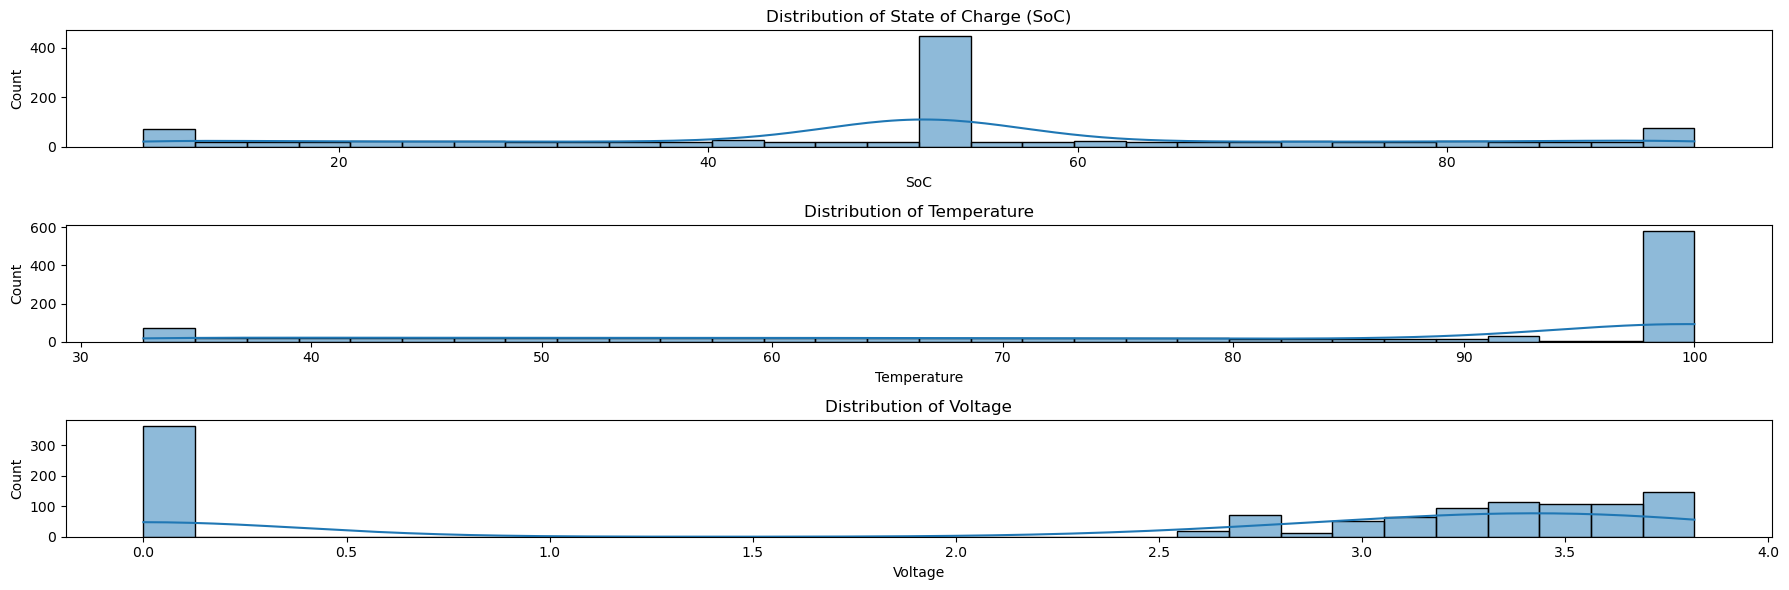

In [8]:
plt.figure(figsize=(18, 6))

# SoC distribution
plt.subplot(3, 1, 1)
sns.histplot(df['SoC'], kde=True, bins=30)
plt.title('Distribution of State of Charge (SoC)')

# Temperature distribution
plt.subplot(3, 1, 2)
sns.histplot(df['Temperature'], kde=True, bins=30)
plt.title('Distribution of Temperature')

# Voltage distribution
plt.subplot(3, 1, 3)
sns.histplot(df['Voltage'], kde=True, bins=30)
plt.title('Distribution of Voltage')

plt.tight_layout()
plt.show()

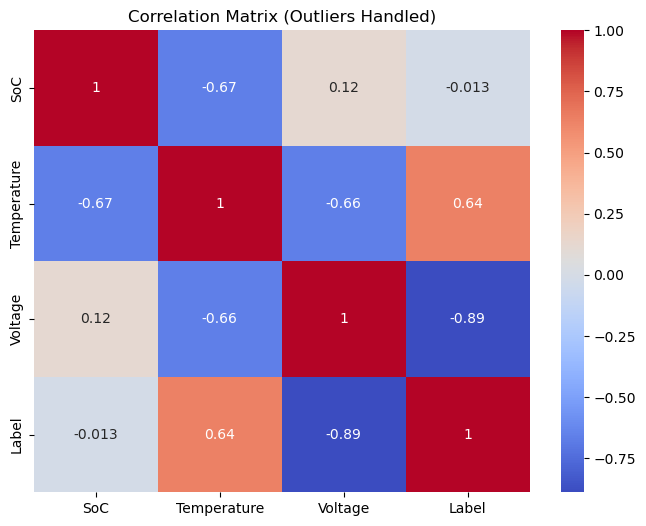

In [9]:
plt.figure(figsize=(8, 6))
corr_matrix = df[['SoC', 'Temperature', 'Voltage', 'Label']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Outliers Handled)')
plt.show()

## Step 2: Define Fire Risk Thresholds

In [10]:
temp_threshold = 77
voltage_low_threshold = 3.0
voltage_high_threshold = 4.2
soc_low_threshold = 10
soc_high_threshold = 90

# Step 3: Analyze the Dataset and Add Fire Risk Column

In [11]:
df['Fire Risk'] = 0  # Initialize Fire Risk column

### Conditions for Fire Risk

In [12]:
# Create a Fire Risk Score (Regression Target)
df['Fire Risk Score'] = 0
df.loc[df['Temperature'] > temp_threshold, 'Fire Risk Score'] += 0.3
df.loc[df['Voltage'] < voltage_low_threshold, 'Fire Risk Score'] += 0.3
df.loc[df['Voltage'] > voltage_high_threshold, 'Fire Risk Score'] += 0.3
df.loc[df['SoC'] < soc_low_threshold, 'Fire Risk Score'] += 0.3
df.loc[df['SoC'] > soc_high_threshold, 'Fire Risk Score'] += 0.3
df.loc[df['Label'].isin([1, 2]), 'Fire Risk Score'] += 0.5

## Step 4: Display Fire Risk Analysis

In [13]:
print("\nFire Risk Analysis:")
print(df[['SoC', 'Temperature', 'Voltage', 'Fire Risk Score']].head(20))


Fire Risk Analysis:
          SoC  Temperature   Voltage  Fire Risk Score
0   93.385102    32.720707  3.817903              0.3
1   93.385102    32.720707  3.817903              0.3
2   93.385102    32.720707  3.817903              0.3
3   93.385102    32.720707  3.817903              0.3
4   93.385102    32.720707  3.817903              0.3
5   93.385102    32.720707  3.817903              0.3
6   93.385102    32.720707  3.817903              0.3
7   93.385102    32.720707  3.817903              0.3
8   93.385102    32.720707  3.817903              0.3
9   92.558240    32.720707  3.817903              0.3
10  91.731378    32.766264  3.817903              0.3
11  90.904515    33.476008  3.817903              0.3
12  90.077653    34.171088  3.817903              0.3
13  89.250791    34.850494  3.817903              0.0
14  88.423929    35.513776  3.817903              0.0
15  87.597066    36.161021  3.817903              0.0
16  86.770204    36.792668  3.811862              0.0
17  85.

### Visualizing Distribution  of Fire Risk

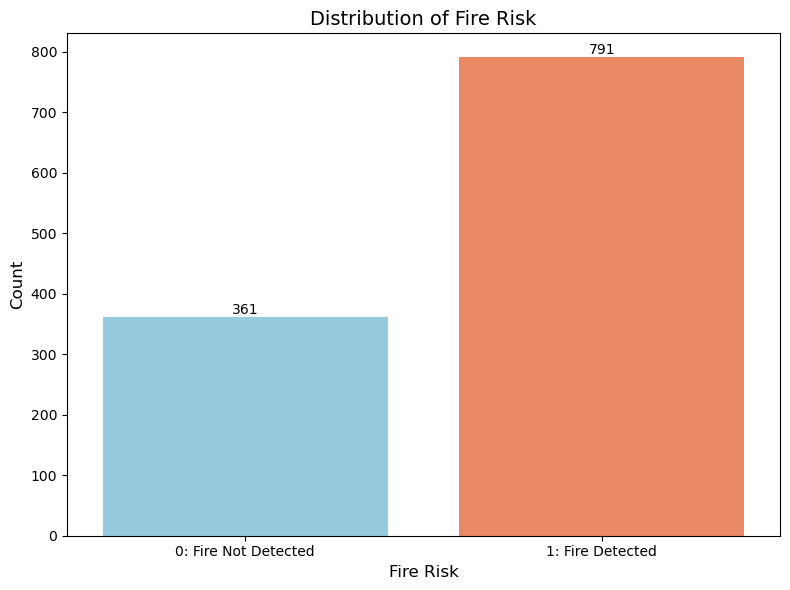

In [14]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Create the bar plot
sns.countplot(x='Fire Risk', data=df, palette=['skyblue', 'coral'])  # Use countplot for discrete values

# Set plot title and labels
plt.title('Distribution of Fire Risk', fontsize=14)
plt.xlabel('Fire Risk', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['0: Fire Not Detected', '1: Fire Detected'], fontsize=10)  # Custom x-axis labels

# Add count labels on top of the bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

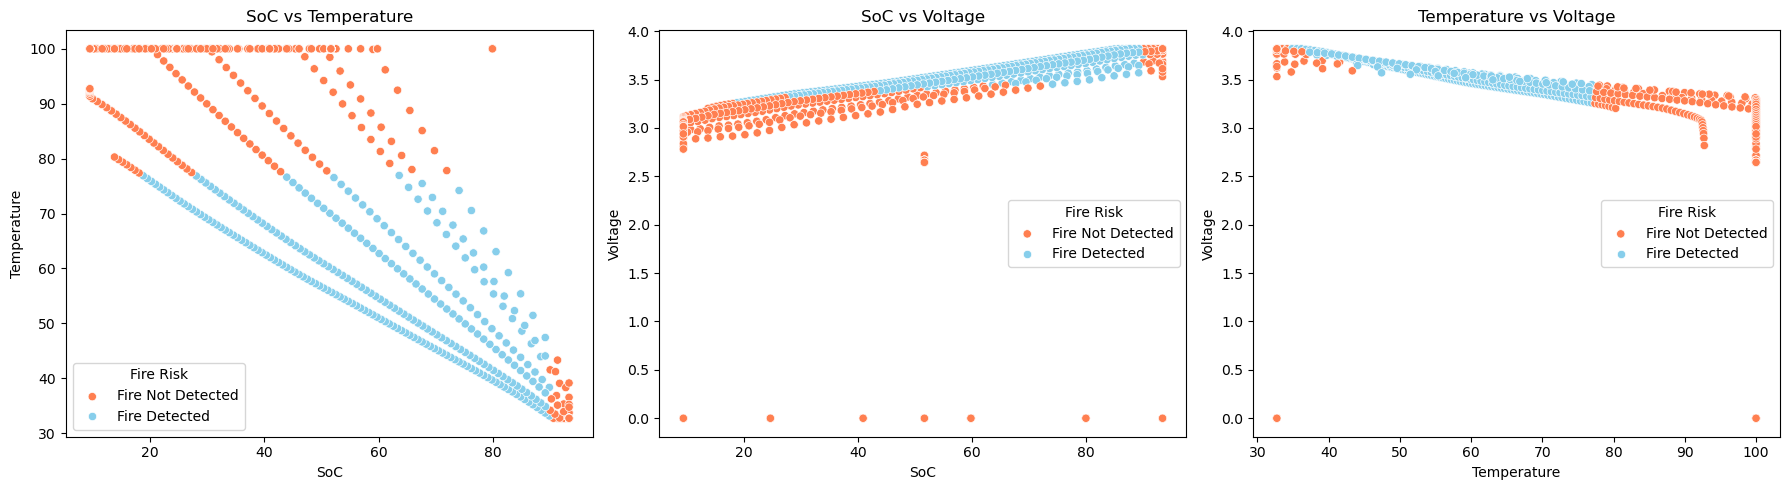

In [30]:
plt.figure(figsize=(18, 5))

# SoC vs Temperature
plt.subplot(1, 3, 1)
sns.scatterplot(x='SoC', y='Temperature', hue='Fire Risk', data=df, palette={0: 'skyblue', 1: 'coral'})
plt.title('SoC vs Temperature')
plt.legend(title='Fire Risk', labels=['Fire Not Detected', 'Fire Detected'])

# SoC vs Voltage
plt.subplot(1, 3, 2)
sns.scatterplot(x='SoC', y='Voltage', hue='Fire Risk', data=df, palette={0: 'skyblue', 1: 'coral'})
plt.title('SoC vs Voltage')
plt.legend(title='Fire Risk', labels=['Fire Not Detected', 'Fire Detected'])

# Temperature vs Voltage
plt.subplot(1, 3, 3)
sns.scatterplot(x='Temperature', y='Voltage', hue='Fire Risk', data=df, palette={0: 'skyblue', 1: 'coral'})
plt.title('Temperature vs Voltage')
plt.legend(title='Fire Risk', labels=['Fire Not Detected', 'Fire Detected'])

plt.tight_layout()
plt.show()

## Step 5: Train Model to Predict Fire Risk

In [16]:
# Separate features and target
X = df[['SoC', 'Temperature', 'Voltage']]
y = df['Fire Risk']

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training and Evaluation

### Define a Function to Evaluate Models

In [19]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

    # Train the model
    model.fit(X_train, y_train)

    # Test the model
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("-" * 60)

In [20]:
# Algorithms to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

In [21]:
# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}:")
    evaluate_model(model, X_train, y_train, X_test, y_test)

Evaluating Logistic Regression:
Cross-Validation Accuracy: 0.8861 (±0.0302)
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        80
           1       0.92      0.87      0.90       151

    accuracy                           0.87       231
   macro avg       0.85      0.87      0.86       231
weighted avg       0.87      0.87      0.87       231

Confusion Matrix:
[[ 69  11]
 [ 19 132]]
Test Accuracy: 0.8701
------------------------------------------------------------
Evaluating Random Forest:
Cross-Validation Accuracy: 0.9978 (±0.0027)
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00       151

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231

Confusion Matrix:
[[ 80   0]
 

In [22]:
# Hyperparameter Tuning with GridSearchCV
# Example: Tuning Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [23]:
# Best parameters and model
print("Best Parameters for Random Forest:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_test, y_pred_best))
print(f"Test Accuracy for Best Model: {accuracy_score(y_test, y_pred_best):.4f}")

Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00       151

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231

Confusion Matrix for Best Model:
[[ 80   0]
 [  0 151]]
Test Accuracy for Best Model: 1.0000


In [24]:
# Predict Fire Risk for New Data
new_data = np.array([[95, 34, 3.5]])  # Example input (SoC, Temperature, Voltage)
new_data_scaled = scaler.transform(new_data)
predicted_fire_risk = best_model.predict(new_data_scaled)

# Convert prediction to a meaningful message
if predicted_fire_risk[0] == 1:
    print('\nPredicted Fire Risk: Fire Detected')
else:
    print('\nPredicted Fire Risk: Fire Not Detected')


Predicted Fire Risk: Fire Detected


In [25]:
new_data = np.array([[95, 77, 3.5]])  # Example input (SoC, Temperature, Voltage)
new_data_scaled = scaler.transform(new_data)
predicted_fire_risk = best_model.predict(new_data_scaled)

# Convert prediction to a meaningful message
if predicted_fire_risk[0] == 1:
    print('\nPredicted Fire Risk: Fire Detected')
else:
    print('\nPredicted Fire Risk: Fire Not Detected')


Predicted Fire Risk: Fire Detected


In [26]:
new_data = np.array([[20, 56, 3.5]])  # Example input (SoC, Temperature, Voltage)
new_data_scaled = scaler.transform(new_data)
predicted_fire_risk = best_model.predict(new_data_scaled)

# Convert prediction to a meaningful message
if predicted_fire_risk[0] == 1:
    print('\nPredicted Fire Risk: Fire Detected')
else:
    print('\nPredicted Fire Risk: Fire Not Detected')


Predicted Fire Risk: Fire Not Detected


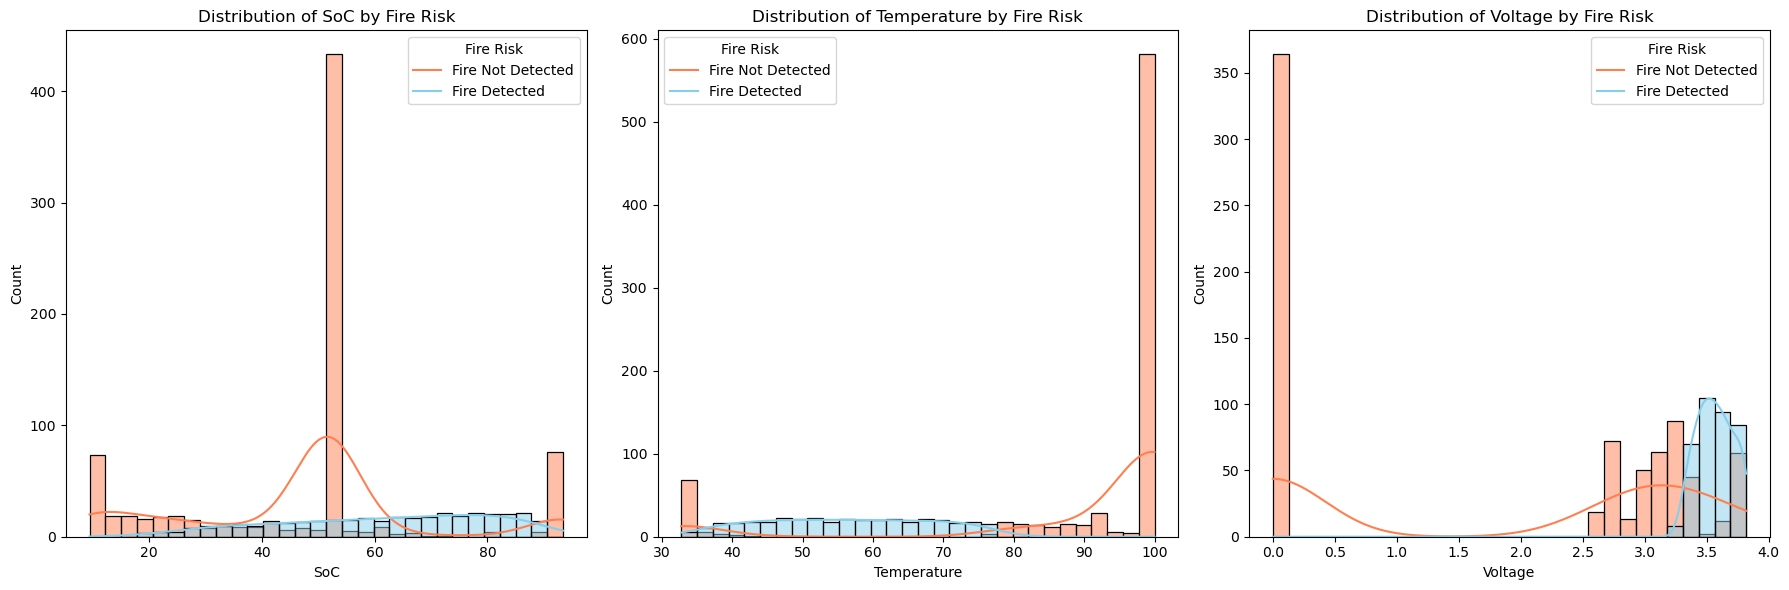

In [27]:
# --- Visualization of Feature Distributions by Fire Risk ---
plt.figure(figsize=(18, 6))

for i, col in enumerate(['SoC', 'Temperature', 'Voltage'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df, x=col, hue='Fire Risk', kde=True, palette={0: 'skyblue', 1: 'coral'}, bins=30)
    plt.title(f'Distribution of {col} by Fire Risk')
    plt.legend(title='Fire Risk', labels=['Fire Not Detected', 'Fire Detected'])

plt.tight_layout()
plt.show()

## Export Pickle File

In [28]:
# Create the 'model' directory if it doesn't exist
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)

# Export the model
with open(os.path.join(model_dir, 'fire_risk_model.pkl'), 'wb') as file:
    pickle.dump(best_model, file)